# Analysing the 1D shock tube test

Sackur–Tetrode equation: entropy of an monatomic ideal gas ($\gamma = 5/3$)
$$
\frac{S}{k_{\rm B} N} = \ln
\left[ \frac{V}{N} \left(\frac{4\pi m}{3h^2}\frac{U}{N}\right)^{3/2}\right]+
{\frac{5}{2}}
$$
Specific entropy expressed in terms of pressure and density
$$
s = \frac{k_B}{m_H} \left\{ \ln\left[m_H^4 \left(\frac{2\pi}{h^2}\right)^{3/2}\frac{P}{\rho^{\gamma}}\right] + \frac{5}{2} \right\}
$$

In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import matplotlib.pyplot as plt
import unyt as u

import richio
import _nb
import dev

In [139]:
snap_dir = '/home/hey4/rich_tde/data/raw/ShockTubeIdealGasGamma1.001/PL7.0PR0.1000DL1.0DR0.125'
!ls $snap_dir

leftdensity.txt    snap_12.h5	 snap_18       snap_22.pvtu  snap_5.h5
leftpressure.txt   snap_12.pvtu  snap_18.h5    snap_23	     snap_5.pvtu
rightdensity.txt   snap_13	 snap_18.pvtu  snap_23.h5    snap_6
rightpressure.txt  snap_13.h5	 snap_19       snap_23.pvtu  snap_6.h5
snap_0		   snap_13.pvtu  snap_19.h5    snap_24	     snap_6.pvtu
snap_0.h5	   snap_14	 snap_19.pvtu  snap_24.h5    snap_7
snap_0.pvtu	   snap_14.h5	 snap_2        snap_24.pvtu  snap_7.h5
snap_1		   snap_14.pvtu  snap_2.h5     snap_25	     snap_7.pvtu
snap_1.h5	   snap_15	 snap_2.pvtu   snap_25.h5    snap_8
snap_1.pvtu	   snap_15.h5	 snap_20       snap_25.pvtu  snap_8.h5
snap_10		   snap_15.pvtu  snap_20.h5    snap_3	     snap_8.pvtu
snap_10.h5	   snap_16	 snap_20.pvtu  snap_3.h5     snap_9
snap_10.pvtu	   snap_16.h5	 snap_21       snap_3.pvtu   snap_9.h5
snap_11		   snap_16.pvtu  snap_21.h5    snap_4	     snap_9.pvtu
snap_11.h5	   snap_17	 snap_21.pvtu  snap_4.h5     snap_final
snap_11.pvtu	   snap_17.h5	 snap_22      

In [140]:
snap = richio.load(os.path.join(snap_dir, 'snap_final.h5'))

## The profiles

In [141]:
from dev.rs import RiemannSolver
# Left State
rho_L = 1.0
vx_L = 0.0
P_L = 1
# Right State
rho_R = 0.125
vx_R = 0.0
P_R = 0.1
# ideal gas gamma
gamma = 5/3

gamma = dev.parse_gamma(snap_dir)
P_L, P_R, rho_L, rho_R = dev.fetch_ic(snap_dir)

# time
t = snap.time.value

# Riemann Solver
rs = RiemannSolver(rho_L, vx_L, P_L, rho_R, vx_R, P_R, gamma, t)
x, rho, vx, P = rs.solve()

x *= richio.units.system["length"]
rho *= richio.units.system["density"]
vx *= richio.units.system["velocity"]
P *= richio.units.system["pressure"]

In [142]:
# Get sh front position
i_sh = dev.get_shock_tube_front(snap.x, snap.dissipation)
x_sh = snap.x[i_sh]

# Near the neighbor of the sh front
x1 = x_sh * 1.05  # upstream
x2 = x_sh * 0.95  # downstream

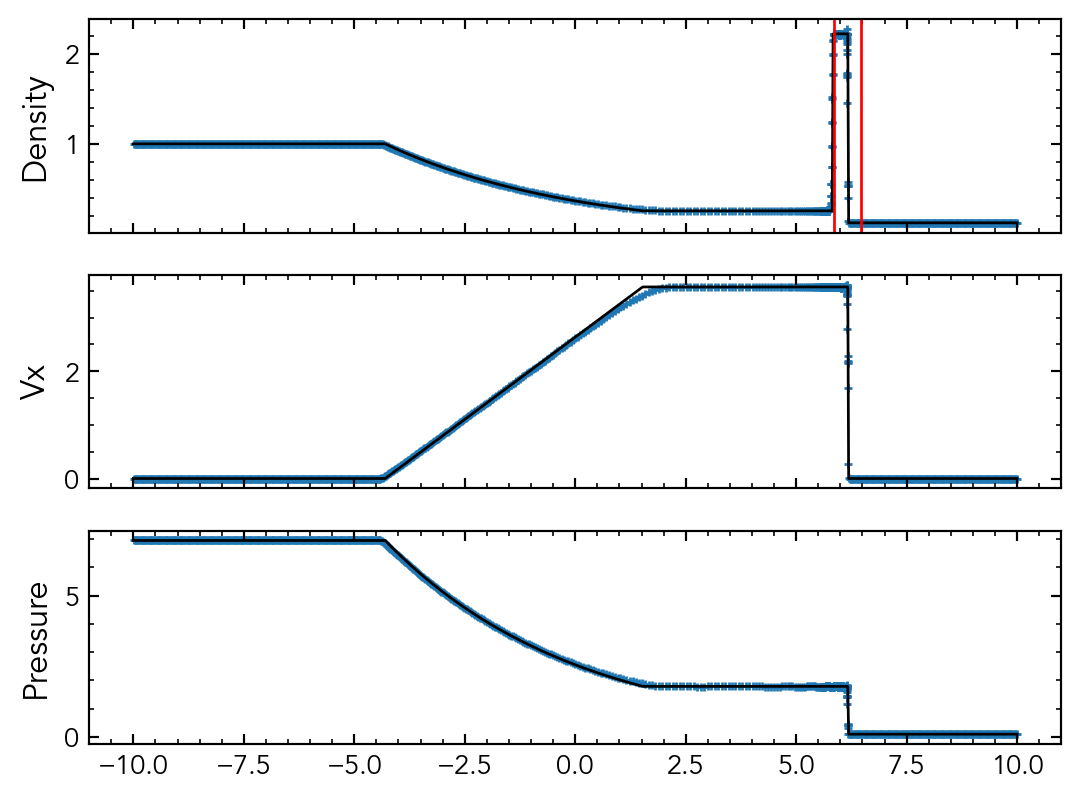

In [143]:
fig, ax = plt.subplots(3, 1, sharex=True)

ax[0].plot(x, rho, color='k')
ax[0].scatter(snap.x, snap.density, marker='+',  s=10)
ax[0].set_ylabel('Density')

ax[0].axvline(x1.value, color='r')
ax[0].axvline(x2.value, color='r')

ax[1].plot(x, vx, color='k')
ax[1].scatter(snap.x, snap.velocity_x, marker='+',  s=10)
ax[1].set_ylabel('Vx')

ax[2].plot(x, P, color='k')
ax[2].scatter(snap.x, snap.P, marker='+',  s=10)
ax[2].set_ylabel('Pressure')

plt.show()

In [144]:
# Specific entropy
s = dev.dp2s(snap.rho, snap.P, gamma=gamma)
s = (s * snap.density / snap.density).in_base('rich') # unit hack

# Specific entropy of the analytical solution
s_exact = dev.dp2s(rho, P, gamma=gamma)
# Create new quantity with rich registry
s_exact = u.unyt_array(
    s_exact.value,  # or s_exact.value
    s_exact.units,
    registry=richio.units.registry
)
s_exact = s_exact.in_base('rich')

In [145]:
# Temperature
T = snap.P / snap.density * u.mh / u.kb

# Analytical solution of temperature
T_exact = P / rho * u.mh / u.kb

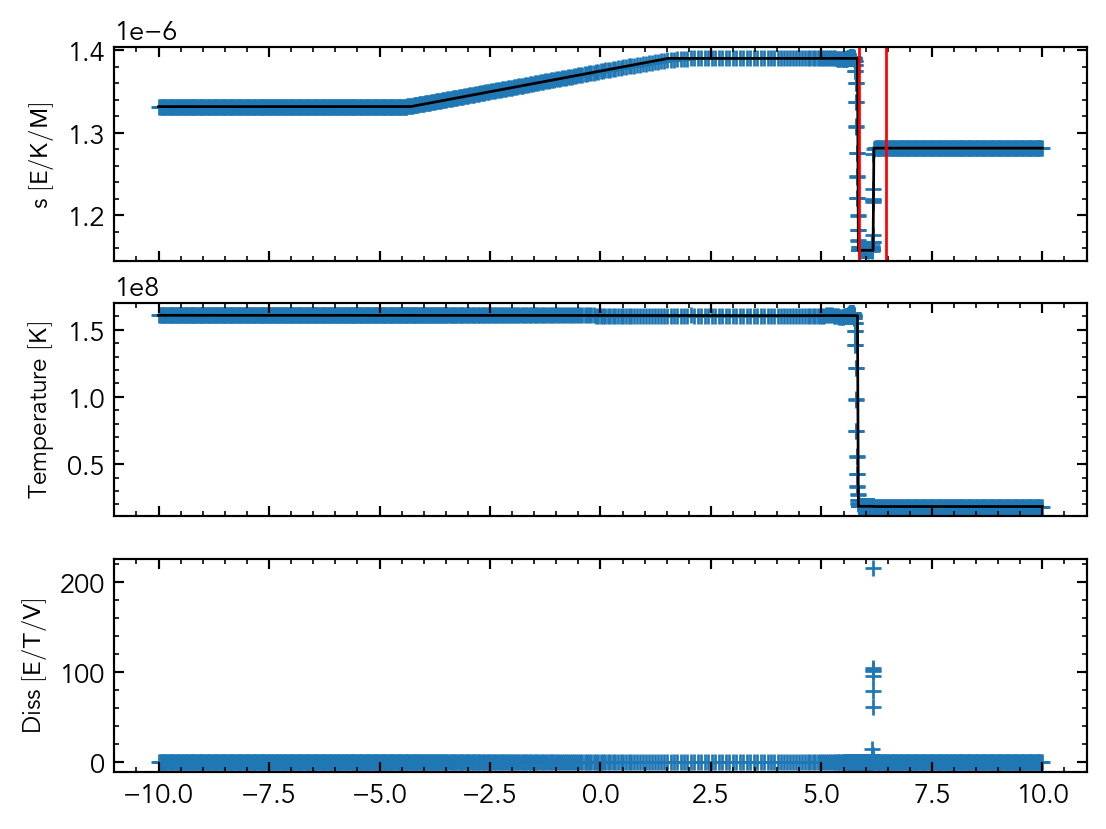

In [146]:
fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].scatter(snap.x, s, marker='+')
ax[0].plot(x, s_exact, color='k')
ax[0].set_ylabel(r's $\mathsf{[E/K/M]}$', fontsize=9)

ax[0].axvline(x1.value, color='r')
ax[0].axvline(x2.value, color='r')

ax[1].scatter(snap.x, T, marker='+')
ax[1].plot(x, T_exact, color='k')
ax[1].set_ylabel(r'Temperature $\mathsf{[K]}$', fontsize=9)

ax[2].scatter(snap.x, snap.dissipation, marker='+')
ax[2].set_ylabel(r'Diss $\mathsf{[E/T/V]}$', fontsize=9)

plt.show()

### Measure sh speed

In [147]:
_xs = []
_ts = []
for file in os.listdir(snap_dir):
    if file.endswith('h5'):
        _snap = richio.load(os.path.join(snap_dir, file))
        i_shfront = dev.get_shock_tube_front(_snap.x, _snap.dissipation) # sh front as the maximum of dissipation, good enough for sod sh; be careful in other setups
        _x = _snap.x[i_shfront]
        _t = _snap.time[0]

        _xs.append(_x)
        _ts.append(_t)

_xs = u.unyt_array(_xs)
_ts = u.unyt_array(_ts)

3.775117722698236 code_length/code_time 0.008801851156458726 code_length


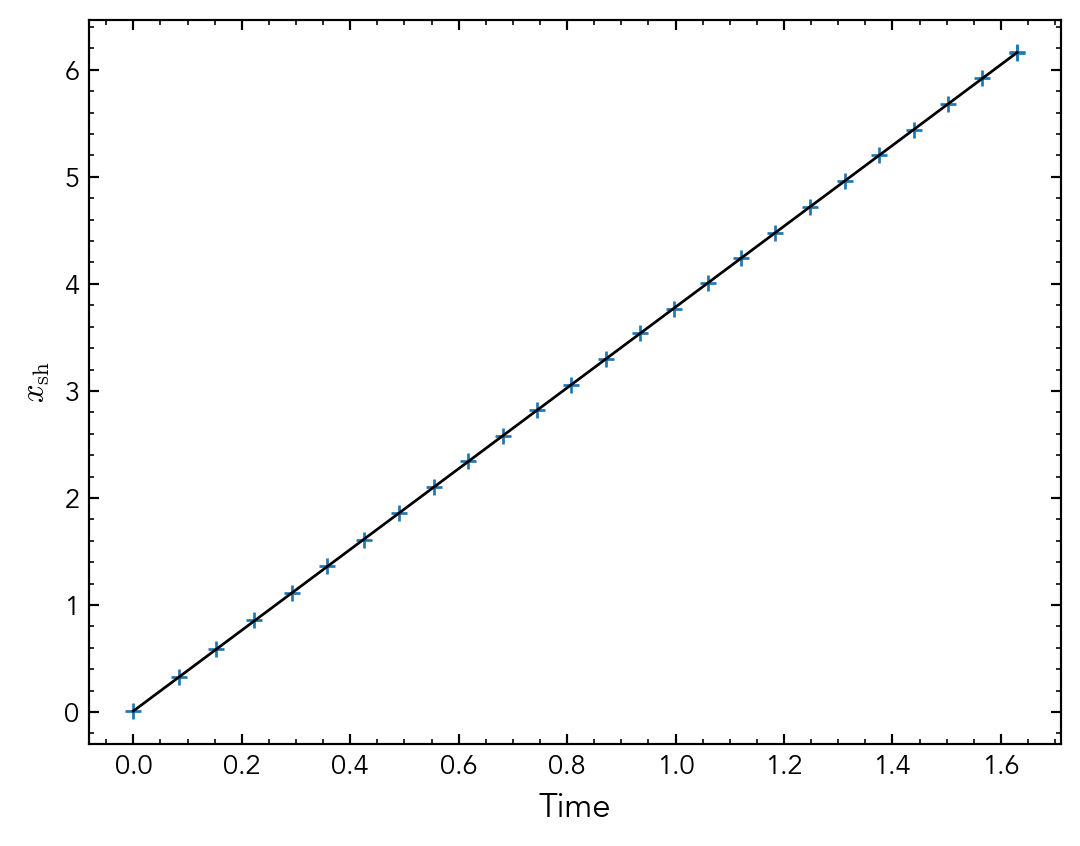

In [148]:
v_sh, b = np.polyfit(_ts.value, _xs.value, 1)
v_sh *= richio.units.lscale / richio.units.tscale
b *= richio.units.lscale
print(v_sh, b)

plt.scatter(_ts, _xs, marker='+')
_t = np.linspace(np.min(_ts), np.max(_ts), 100, True)
plt.plot(_t, _t*v_sh + b, color='k')
plt.xlabel('Time')
plt.ylabel(r'$x_\mathrm{sh}$')
plt.show()

### Verify jump conditions
$$
\frac{\rho_1}{\rho_2} = \frac{\gamma - 1}{\gamma + 1} + \frac{2}{(\gamma + 1) M^2}
$$
$$
\frac{P_2}{P_1} = \frac{2\gamma M^2}{\gamma + 1} - \frac{\gamma - 1}{\gamma + 1}
$$
$$
\frac{u_2}{u_1} = \frac{P_2}{P_1}\frac{\rho_1}{\rho_2}
$$

In [149]:
T1 = dev.get_at_x(snap, T, x=x1)
T2 = dev.get_at_x(snap, T, x=x2)
s1 = dev.get_at_x(snap, s, x=x1)
s2 = dev.get_at_x(snap, s, x=x2)
u1 = dev.get_at_x(snap, snap.sie, x=x1)
u2 = dev.get_at_x(snap, snap.sie, x=x2)
rho1 = dev.get_at_x(snap, snap.rho, x=x1)
rho2 = dev.get_at_x(snap, snap.rho, x=x2)
P1 = dev.get_at_x(snap, snap.P, x=x1)
P2 = dev.get_at_x(snap, snap.P, x=x2)
v1_lab = dev.get_at_x(snap, snap.vx, x=x1) # lab frame
v2_lab = dev.get_at_x(snap, snap.vx, x=x2)
v1_sh = v_sh - v1_lab
v2_sh = v_sh - v2_lab

In [150]:
# Mach number
P1 = dev.get_at_x(snap, snap.P, x=x1)
M = np.sqrt(rho1 * v_sh**2 / (P1 * gamma)) # M = v_sh / c_1
print("The Mach number of the sh is", M)

The Mach number of the sh is 4.218601151994378 dimensionless


In [151]:
rho1_to_rho2 = (gamma - 1)/(gamma + 1) + 2/(gamma + 1)/M**2
P2_to_P1 = (2*gamma*M**2)/(gamma + 1) - (gamma - 1)/(gamma + 1)

In [152]:
# This is mostly a sanity check
# Because the riemann solver (exact) solution gives the jump condition exactly
# And we see RICH matches the riemann solver solution very well
print(f"rho1/rho2 analytically from the Mach number: {rho1_to_rho2}")
print(f"rho1/rho2 actually in the sim: {rho1 / rho2}\n")
print(f"P2/P1 from the Mach number: {P2_to_P1}")
print(f"P2/P1 actually in the sim: {P2 / P1}")

rho1/rho2 analytically from the Mach number: 0.05666219084500793 dimensionless
rho1/rho2 actually in the sim: 0.056425989210134 dimensionless

P2/P1 from the Mach number: 17.804989780397694 dimensionless
P2/P1 actually in the sim: 17.872405579492142 dimensionless


In [153]:
print(f"v2/v1 which should be equal to rho1/rho2 {v2_sh / v1_sh}")

v2/v1 which should be equal to rho1/rho2 0.05517745772561112 dimensionless


In [154]:
# specific heat
cv = u.kb/u.mh/(gamma - 1)

In [155]:
s2_minus_s1 = cv * (np.log(P2_to_P1) + gamma * np.log(rho1_to_rho2))
print(f"s2 - s1 analytically from the Mach number {(s2_minus_s1).in_cgs()}")
print(f"s2 - s1 actually in the sim: {(s2 - s1).in_cgs()}") #TODO: derive sackur-tetrode equation for varying gamma

s2 - s1 analytically from the Mach number 491632927.3563376 cm**2/(K*s**2)
s2 - s1 actually in the sim: -236098321.49942395 cm**2/(K*s**2)


In [156]:
# Total dissipation rate (dissipation rate at sh front as well)
diss = snap.dissipation * snap.volume
total_diss = np.sum(diss)
print(f"The total dissipation rate is {total_diss}")

i_sh = (snap.x > x2) & (snap.x < x1)
diss_sh = np.sum(diss[i_sh])
print(f"Dissipation rate across the sh front is {diss_sh}")

The total dissipation rate is 0.0008826148676741324 code_length**2*code_mass/code_time**3
Dissipation rate across the sh front is 0.0008820880250796079 code_length**2*code_mass/code_time**3


In [157]:
# Cross section
A = (snap.box_size[4] - snap.box_size[1]) * (snap.box_size[5] - snap.box_size[2])
print(f'The cross section is: {A}')

The cross section is: 0.0004 code_length**2


### Comparison 2
$$
\mathrm{Diss}\,\mathrm{[E/T]} = (u_2 - u_1)\rho_1 v_\mathrm{sh} A
$$
subscript 1 for upstream, 2 for downstream. (Extremely strong shock)

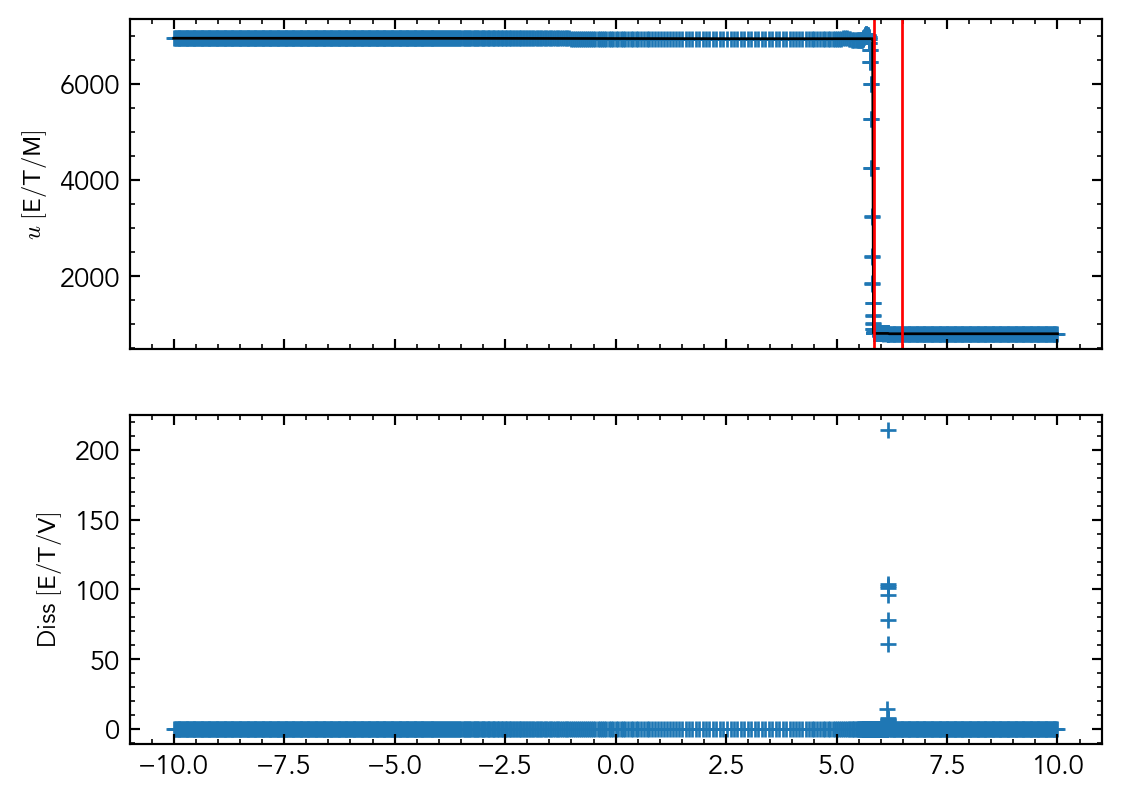

In [158]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].scatter(x=snap.x, y=snap.sie, marker='+')
ax[0].plot(x, P/rho/(gamma-1), color='k')
ax[0].set_ylabel(r'$u$ $\mathsf{[E/T/M]}$', fontsize=9)
ax[0].axvline(x1.value, color='r')
ax[0].axvline(x2.value, color='r')

ax[1].scatter(snap.x, snap.dissipation, marker='+')
ax[1].set_ylabel(r'Diss $\mathsf{[E/T/V]}$', fontsize=9)

plt.show()

In [159]:
# Total dissipation rate diagnostic
# diss_ie = (u2 - u1) * rho1 * v_sh * A
diss_ie = (u2 * rho2 * v2_sh - u1 * rho1 * v1_sh) * A # (u2 - u1)* rho1 * v_sh * A
print(diss_ie)

-0.0020908257990666698 code_length**2*code_mass/code_time**3


In [160]:
(u2 - u1)* rho1 * v_sh * A # by rho2 v2 = rho1 v1 and v1 ~ v_sh

unyt_quantity(0.00127873, 'code_length**2*code_mass/code_time**3')

In [161]:
diss_ie/diss_sh

unyt_quantity(-2.37031423, '(dimensionless)')

### Comparison 3: Schaal+14, 16; Ryu+03
$$
\begin{gather}
E_\mathrm{diss} = \frac{1}{2} \rho_1 v_\mathrm{sh}^3 A \delta (M)
\\
\delta(M) = \frac{2}{\gamma(\gamma - 1)M^2 R} \left[\frac{2\gamma M^2 - (\gamma - 1)}{\gamma + 1} - R^\gamma\right]
\\
R = \frac{\rho_2}{\rho_1}
\end{gather}
$$

In [162]:
R = 1/((gamma - 1)/(gamma + 1) + 2/(gamma + 1)/M**2)
deltaM = 2/(gamma*(gamma - 1) * M**2 * R) * ((2*gamma*M**2 - (gamma - 1))/(gamma + 1) - R**gamma)
diss_schaal = 1/2*rho1*v_sh**3*A*deltaM
print(diss_schaal)

0.0009052666696103353 code_length**2*code_mass/code_time**3


In [163]:
print('RICH:', diss_sh, '\n', 'Schaal+16:', diss_schaal, '\n', 'Internal energy jump:', diss_ie)

RICH: 0.0008820880250796079 code_length**2*code_mass/code_time**3 
 Schaal+16: 0.0009052666696103353 code_length**2*code_mass/code_time**3 
 Internal energy jump: -0.0020908257990666698 code_length**2*code_mass/code_time**3


In [164]:
(u2 * rho2 - u1 * (rho2/rho1)**gamma * rho1) * v2_sh * A # Also Schaal, without the delta(M) parametrisation, just utot + pdV

unyt_quantity(0.00082532, 'code_length**2*code_mass/code_time**3')

### Near shock front

In [165]:
#The max dissipation cell
i_maxdiss = np.argmax(snap.dissipation)
print(i_maxdiss)

764


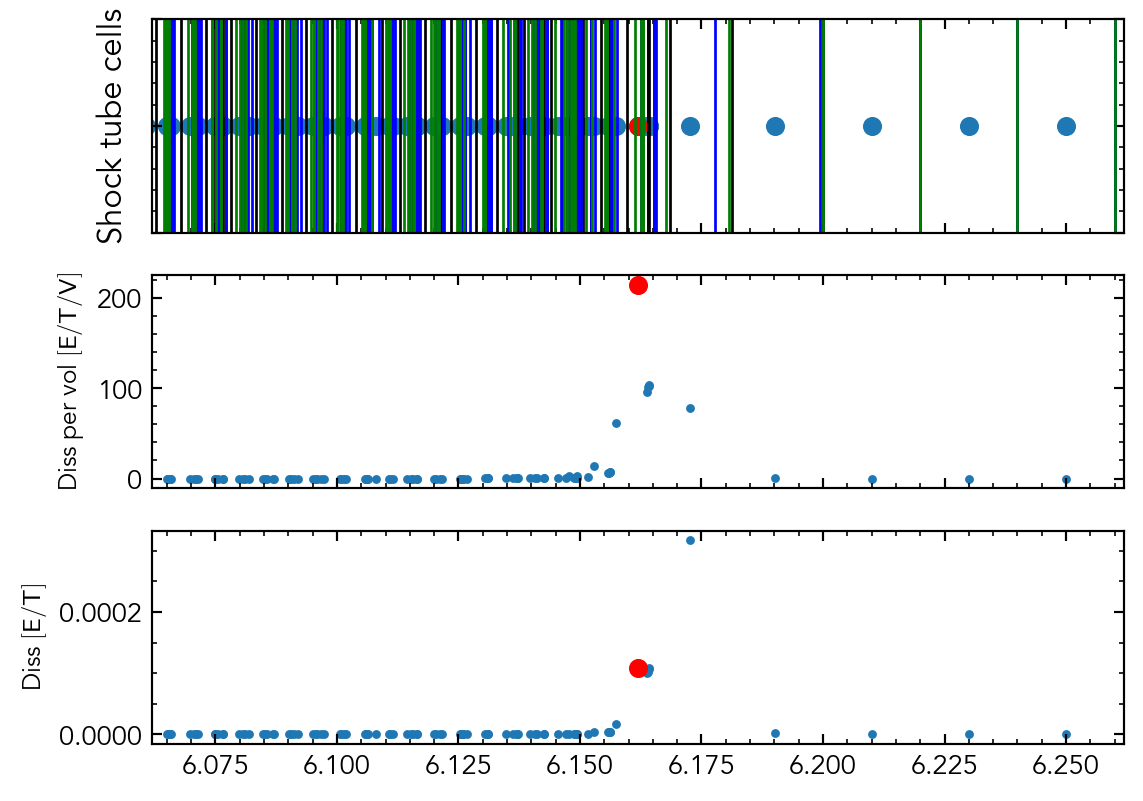

In [166]:
# Looking at the shock front
fig, ax = plt.subplots(3, 1, sharex=True)

ax[0].scatter(snap.x, np.ones_like(snap.x))
ax[0].scatter(snap.x[i_maxdiss], 1, color='r')

# Voronoi lines
i_sortx = np.argsort(snap.x)
x_sorted = snap.x[i_sortx]
ax[0].vlines((x_sorted[1:] + x_sorted[:-1])/2, ymin=0, ymax=2, color='k')

# Volume splitting
lcell = snap.volume / A
ax[0].vlines(snap.x + lcell/2, ymin=0, ymax=2, color='b')
ax[0].vlines(snap.x - lcell/2, ymin=0, ymax=2, color='g')

ax[0].set_ylabel(r'Shock tube cells')
ax[0].set_ylim(0, 2)
ax[0].set_yticklabels('')

ax[1].scatter(snap.x, snap.dissipation, s=5)
ax[1].scatter(snap.x[i_maxdiss], snap.dissipation[i_maxdiss], color='r')
ax[1].set_ylabel(r'Diss per vol $\mathsf{[E/T/V]}$', fontsize=9)

ax[2].scatter(snap.x, snap.dissipation * snap.volume, s=5)
ax[2].scatter(snap.x[i_maxdiss], snap.dissipation[i_maxdiss] * snap.volume[i_maxdiss], color='r')

ax[2].set_ylabel(r'Diss $\mathsf{[E/T]}$', fontsize=9)

plt.xlim(snap.x[i_maxdiss].value-0.1, snap.x[i_maxdiss].value+0.1)

plt.show()

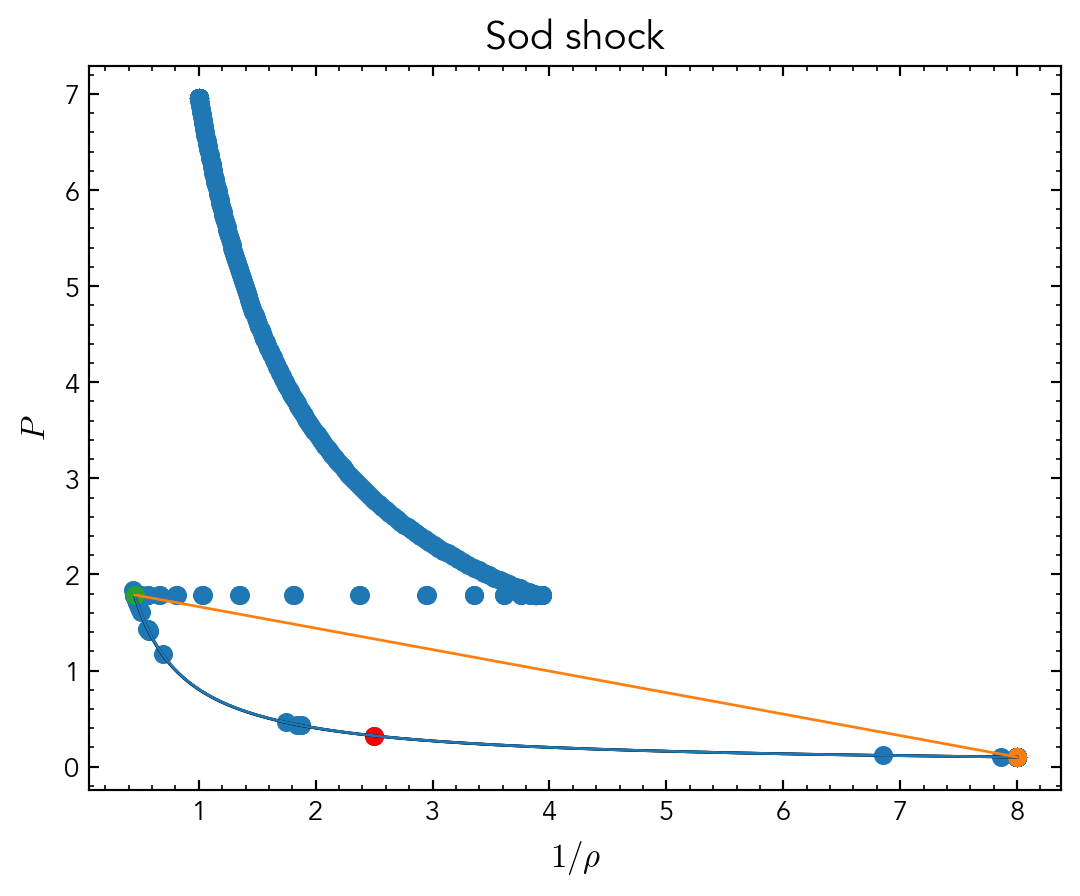

In [167]:
# P-rho^-1 diagram
def P_adiabatic(rho, P_ref, rho_ref):
    return P_ref * (rho/rho_ref)**gamma

def P_hugoniot(rho, P_ref, rho_ref): # uses rho2, P2 as reference point
    return P_ref * ((gamma + 1)*rho - (gamma - 1)*rho_ref) / ((gamma + 1)*rho_ref - (gamma - 1)*rho)

# Rayleigh line (straight line in P-v plane)
v1 = 1/rho1
v2 = 1/rho2
def P_rayleigh(v):
    return P1 + (P2 - P1)*(v - v1)/(v2 - v1)

Vspace = np.linspace(v2, v1, 1000)
plt.plot(Vspace, P_adiabatic(1/Vspace, P1, rho1), color='k')
plt.plot(Vspace, P_adiabatic(1/Vspace, P2, rho2), color='k')

plt.plot(Vspace, P_hugoniot(1/Vspace, P2, rho2))
plt.plot(Vspace, P_rayleigh(Vspace))

plt.scatter(1/snap.rho, snap.P)
plt.scatter(1/rho1, P1)
plt.scatter(1/rho2, P2)
plt.scatter(1/snap.rho[i_maxdiss], snap.P[i_maxdiss], color='r')

plt.xlabel('$1/\\rho$')
plt.ylabel('$P$')
plt.title('Sod shock')
# plt.savefig('../reports/figures/sod-shocktube-adiabat.png', dpi=200)
plt.show()

In [168]:
# Use a linear spacing for specific volume v
v_axis = np.linspace(v2, v1, 3000) 
P2 = P_hugoniot(rho2, P1, rho1)

# Calculate pressures along the v_axis
P_R = P1 + (P2 - P1) * (v_axis - v1) / (v2 - v1)
P_H = P_hugoniot(1.0 / v_axis, P_ref=P2, rho_ref=rho2)
P_A = P_adiabatic(1.0 / v_axis, P_ref=P1, rho_ref=rho1)

# Area 1: The "Lens" between Rayleigh and Hugoniot
# This represents the entropy production path deviation
A_h = np.trapezoid(P_R - P_H, v_axis)

# Area 2: The difference between Rayleigh and Adiabat
# This is much larger because P_R ends at P2_shock, not P2_adiabatic
A_p = np.trapezoid(P_R - P_A, v_axis)

In [169]:
rho2/rho1, A_h/A_p, diss_sh/diss_schaal

(unyt_quantity(17.72232998, '(dimensionless)'),
 unyt_quantity(0.99775817, '(dimensionless)'),
 unyt_quantity(0.97439578, '(dimensionless)'))